In [1]:
import numpy as np
import helperfunctions as hf
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

%matplotlib inline
%load_ext autotime
#%autoload

time: 268 µs (started: 2021-01-09 13:35:26 -05:00)


# Model

In [2]:
config= {"input_lower_bound": -4.0,
         "input_uper_bound": np.reshape(4.0,[1,1]),
         "input_dim":4,
         "output_dim":1,
         "hidden1": 28,
         "hidden2":15,
         "hidden3": 0, 
         "lr":0.001,
         "batch_size" : 2000,
         "epochs": 1000,
         "iters": 100,
         "print_it": True,
         "display_interval": 20
         
    }



time: 528 µs (started: 2021-01-09 13:35:26 -05:00)


In [3]:
filename1='NNdataMPC.csv'
filename2='NNdataMPC2.csv'
regions=3
#load_weights = True
load_weights=True
model,crit, min_data, max_data =hf.main_cell(regions,filename1,filename2, config, load_weights=load_weights, test_size=0.05)
if load_weights:
    for j in range(regions):
        filename= 'MPC_model_weight_region'+str(j+1)
        model['region'+str(j+1)].load_state_dict(torch.load(filename))

Input Dimensions :  (30000, 4)
Output Dimensions :  (30000, 1)
data loaded successfully
succesfully assigned regions
succesfully assigned data to each region
data size for region : 0 torch.Size([4058, 4])
training for region  0  complete
data size for region : 1 torch.Size([25744, 4])
training for region  1  complete
data size for region : 2 torch.Size([197, 4])
training for region  2  complete
time: 717 ms (started: 2021-01-09 13:35:26 -05:00)


# Cartpole

In [4]:
import matplotlib.pyplot as plt
import time
%matplotlib inline
import pylab as pl
from IPython import display


time: 4.59 ms (started: 2021-01-09 13:35:30 -05:00)


In [5]:
def rotate_pos(pos, angle):

    rot_mat = np.array([[np.cos(angle), -np.sin(angle)],
                        [np.sin(angle), np.cos(angle)]])
    return np.dot(pos, rot_mat.T)

def square(center_x, center_y, shape, angle):

    #square_xy = np.array([shape[0], shape[1]])
    square_xy = np.array([[shape[0], shape[1]],
                              [-shape[0], shape[1]],
                              [-shape[0], -shape[1]],
                              [shape[0], -shape[1]],
                              [shape[0], shape[1]]])
    # translate position to world
    # rotation
    trans_points = rotate_pos(square_xy, angle)
    # translation
    trans_points += [center_x, center_y]

    return trans_points[:,0], trans_points[:,1]

def coord_cartpole(curr_q,config):

    cart = config["cart"]
    l=config["l"]
    #cart
    cart_x,cart_y = square(curr_q[0], 0., cart, 0.)
    #pend
    pend_x = [curr_q[0], curr_q[0]+l*np.cos(curr_q[2]-np.pi/2)]
    pend_y = [0., l*np.sin(curr_q[2]-np.pi/2)]
    return cart_x,cart_y, pend_x, pend_y





time: 1.13 ms (started: 2021-01-09 13:35:30 -05:00)


In [6]:
config3 = {"l": 1, # length of the pendulum
         "mp": 0.2, # mass of the pendulum
         "Mc": 1, # Mass of the cart
         "g": 9.81, # gravity
         "dt":0.09, # time step for MPC
         "Np": 22, #Horizn length
         "cart" : (0.6,0.2), # dimensions of the cart
         "iters" : 150, # Maximum number of iteration for the solution
         "q11": 12., # state coefficient diag_1
         "q22": 0.09, # diag_2
         "q33": 2., # diag_3
         "q44": 0.1, # diag_3
         "R" : 0.3 # Input Coefficient
         }
def state(curr_q,u,config):
    mp = config["mp"]
    l = config["l"]
    Mc = config["Mc"]
    g = config["g"]
    dt = config["dt"]
    
    #state x
    dq1 = curr_q[1]  # initial state of the cartpole
    # state xdot
    dq2 = (u+mp*np.sin(curr_q[2])*(l*(curr_q[3]**2)
                                          +g*np.cos(curr_q[2])))/(Mc+mp*(np.sin(curr_q[2])**2))
    # state theta
    dq3 = curr_q[3]
    # state thetadot
    dq4 = (-u*np.cos(curr_q[2])-mp*l*(curr_q[3]**2)
               *np.cos(curr_q[2])*np.sin(curr_q[2])
               -(Mc+mp)*g*np.sin(curr_q[2]))/(l*(Mc+mp*
                                                (np.sin(curr_q[2])**2)))
    next_q = curr_q+np.array([dq1,dq2,dq3,dq4])*dt
    for i in range(np.size(next_q)):
        try:
            np.dtype(next_q[i])
        except:
            next_q[i]=next_q[i][0]
    return next_q

time: 977 µs (started: 2021-01-09 13:35:31 -05:00)


In [7]:
max_iter=200
old_q = np.array([0., 0., -np.random.randn(1)[0], 0.])
old_q = torch.tensor(np.reshape(old_q,[1,4]),dtype=torch.float)
old_q1=old_q.detach().numpy()[0]
history_q = [old_q1]


interval = (max_data-min_data)/regions

for i in range(max_iter):
    for j in range(regions):
            upr_limit = (j+1)*interval
            upr_limit +=min_data
            lower_limit = j*interval
            lower_limit +=min_data
            data_sum = np.sum(old_q1)
         

            if (data_sum < upr_limit) and (data_sum >= lower_limit):
                NN = model['region'+str(j+1)]
                u = NN.forward(old_q)
                u = u.detach().numpy()
                u = u[0]


    curr_q = np.array(state(old_q1,u,config3)).astype(float)
    
    history_q.append(curr_q)
    old_q=torch.tensor(curr_q,dtype=torch.float)
    
    old_q1=old_q.detach().numpy()
    


time: 66.5 ms (started: 2021-01-09 13:35:33 -05:00)


/Users/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


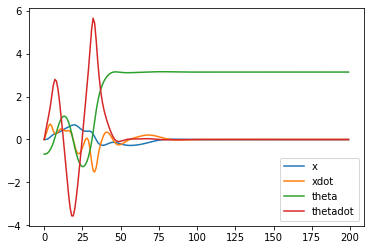

time: 224 ms (started: 2021-01-09 13:35:34 -05:00)


In [8]:
x=[]
xdot=[]
th=[]
thdot=[]
for i in range(max_iter):
    x.append(history_q[i][0])
    xdot.append(history_q[i][1])
    th.append(history_q[i][2])
    thdot.append(history_q[i][3])
 

plt.plot(x)
plt.plot(xdot)
plt.plot(th)
plt.plot(thdot)
plt.legend(['x','xdot','theta','thetadot'])

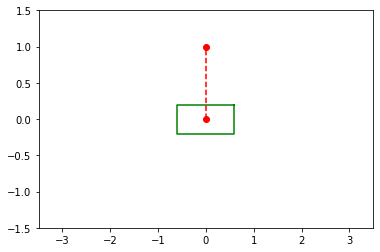

time: 30.5 s (started: 2021-01-09 13:35:37 -05:00)


In [9]:
for i in range(max_iter):
    curr_x = history_q[i]
    x1,y1, x2, y2 = coord_cartpole(curr_x,config3)
    pl.clf()
    pl.plot(x1, y1, 'g-',x2, y2, 'r--o')
    pl.xlim(-3.5, 3.5)
    pl.ylim(-1.5,1.5)
    display.display(pl.gcf())
    display.clear_output(wait=True)
    time.sleep(0.00006)

In [ ]:
#plotx = X_test
#ploty = y_test

#outputs = NN(plotx)
#outputs = NN(X_test)

#state=plotx.detach().numpy().squeeze()
#print(np.shape(state))
#state = np.mean(state,1)
#diff = np.absolute((ploty-outputs).detach().numpy().squeeze())

#plt.plot(state,diff,'r.')
#plt.xlabel('states')
#plt.ylabel('absolute error')

#state1=plotx[:,1:2].detach().numpy().squeeze()

#plt.plot(state1,diff,'g.')


#state1=plotx[:,2:3].detach().numpy().squeeze()

#plt.plot(state1,diff,'b.')


#state1=plotx[:,3:4].detach().numpy().squeeze()

#plt.plot(state1,diff,'y.')
#plt.ylim([0,0.5])
#plt.xlim([-0.2,0.2])

In [ ]:
#for j in range(regions):
#    modelr = model['region'+str(j+1)]
#    filename = 'MPC_model_weight_region'+str(j+1)
#    torch.save(modelr.state_dict(), filename)
#torch.save(NN.state_dict(), 'MPC2_model_weights')
#torch.save(NN.state_dict(), 'MPC3_model_weights')
#torch.save(NN.state_dict(), 'MPC4_model_weights')

#torch.save(NN.state_dict(), 'MPC5_model_weights')

#NN.load_state_dict(torch.load('MPC_model_weights'))
#NN.eval()